#Modeling

In this section, we propose several models to predict whether or not a song has been listened to. We begin with the implementation of several baselines, and proceed with a more advanced model.

In [287]:
!pip install spotipy
!pip install nimfa
!pip install textdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [438]:
import pandas as pd
import numpy as np
import json
import re
import os
from collections import defaultdict
import copy
import spotipy
import nimfa
from sklearn.linear_model import LinearRegression, LogisticRegression
from textdistance import jaccard

In [168]:
def build_relevant_ds(songs: list):
    """
    Preprocesses data, simultaneously building relevant data structures
    
    @param data - a data list of playlist dictionaries to preprocess
    @returns a list of tracks per user, users per track, watered down data list
    """
    
    def process_uri(uri:str):
        """URI Processing method"""
        return uri.split(":")[2]
        
    print("Preprocessing started...")
    tracks_per_user, users_per_track, users_per_artist, artists_per_user = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    
    # Traversing through data and preprocessing
    for song in songs:

      # Obtaining user
      user = song['user']

      # obtaining necessary data
      track, artist, album = song['track_name'], song['artist_name'], song['album_name']
      
      # Appending data to data structures
      tracks_per_user[user].append(track)
      users_per_track[track].append(user)
      users_per_artist[artist].append(user)
      artists_per_user[user].append(artist)
            
    return tracks_per_user, users_per_track, users_per_artist, artists_per_user
            


In [240]:
# Reading in training and testing data
with open('data_train.json', 'r') as train_reader:
  data_train_val = json.load(train_reader)

with open('data_test.json', 'r') as test_reader:
  data_test= json.load(test_reader) 

In [244]:
data_train, data_val = data_train_val[:600_000], data_train_val[600_000:]

In [245]:
val_tracks_per_user, val_users_per_track, val_users_per_artist, val_artists_per_user = build_relevant_ds(data_val)

Preprocessing started...


#### Validation, Test Set Construction

The Validation and Test set are balanced sets of positive and negative instances, maintaining 1/2 positive user-item pairs (the user listened to the song) and 1/2 negative user-item pairs (the user did not listen to the song).

In [246]:
# Adding negative records to validation data (already exist in test data)
val_neg_ex = []

# Sampling negatives
for ex in data_val:
    user = ex['user']
    random_song = ex
    
    # Sampling random songs until one found from different playlist
    while random_song['track_name'] in val_tracks_per_user[user]:
        random_song = data_val[np.random.randint(0, len(data_val))]
    
    # Negative example modification
    neg_ex = copy.deepcopy(random_song)
    neg_ex['listened'] = False

    # Group user with negative example
    neg_ex['user'] = user
    neg_ex['playlist_name'] = ex['playlist_name']
    
    # Appending
    val_neg_ex.append(neg_ex)

data_val += val_neg_ex

In [247]:
test_tracks_per_user, test_users_per_track, test_users_per_artist, test_artists_per_user = build_relevant_ds(data_test)

Preprocessing started...


In [248]:
# Adding negative records to validation data (already exist in test data)
test_neg_ex = []

# Sampling negatives
for ex in data_test:
    user = ex['user']
    random_song = ex
    
    # Sampling random songs until one found from different playlist
    while random_song['track_name'] in test_tracks_per_user[user]:
        random_song = data_test[np.random.randint(0, len(data_test))]
    
    # Negative example modification
    neg_ex = copy.deepcopy(random_song)
    neg_ex['listened'] = False

    # Group user with negative example
    neg_ex['user'] = user
    neg_ex['playlist_name'] = ex['playlist_name']
    
    # Appending
    test_neg_ex.append(neg_ex)

data_test += test_neg_ex

In [249]:
# Storing data as dataframe for easier use
train_df = pd.DataFrame.from_records(data_train)
val_df = pd.DataFrame.from_records(data_val)
test_df = pd.DataFrame.from_records(data_test)

In [250]:
print(f"Validation Length: {len(data_val)}, Test Length: {len(data_test)}")

Validation Length: 400000, Test Length: 400000


##Baseline Models

We implement the following baseline models, and attempt to exceed the performance of both:

1. Totally Naive Baseline: Prediction by Popularity
2. Standard Tier Baseline: Collaborative Filtering
3. Supposedly good baseline: Personalized Logistic Regression

In [253]:
# Necessary data structures
tracks_per_user, users_per_track, users_per_artist, artists_per_user = build_relevant_ds(data_train)

Preprocessing started...


### Motivating Naive Basline: Prediction by Popularity (Unpersonalized Recommendation)

In [254]:
def predict_by_pop(tracks: np.array, most_popular: set):
  """Predicts that a song was listened to if it was among the most popular songs"""
  return [True if track in most_popular else False for track in tracks]

def construct_most_popular(users_per_track: list) -> set:
    """Naive Baseline: Predicts track has been listened to by user if it's in the tracks that account for top 1/2 of listens"""
    # Most popular list init
    most_popular = []

    # Sorting tracks by popularity
    track_popularities = [(len(users_per_track[track]), track) for track in users_per_track]
    track_popularities.sort(reverse = True)

    # Computing half of total listens
    half_tot_popularity = sum([len(users_per_track[track]) for track in users_per_track]) // 2
    
    # init cumulative popularity
    cum_pop, counter = 0,0

    # While haven't accounted for half of total listens
    while(cum_pop < half_tot_popularity):
      # Appending song and adjusting iterators
      most_popular.append(track_popularities[counter][1])
      cum_pop += track_popularities[counter][0]
      counter += 1

    return set(most_popular)


def acc(labels: np.array, predictions: np.array):
  """Accuracy computation"""
  return sum(predictions == labels) / len(labels)


In [ ]:
most_popular = construct_most_popular(users_per_track)

In [ ]:
val_predictions = predict_by_pop(val_df['track_name'], most_popular)
print(f"Val Accuracy: {acc(val_df['listened'], val_predictions)}")

Val Accuracy: 0.499755


In [ ]:
test_predictions = predict_by_pop(test_df['track_name'], most_popular)
print(f"Test Accuracy: {acc(test_df['listened'], test_predictions)}")

Test Accuracy: 0.50026


### Conclusions from extremely naive Baseline

Due to the construction of our validation and test set, prediction by popularity is an entirely ineffective way to build a decision boundary. 

Although the top 55% (55% was the optimal validation parameter) of Popular songs comprise more of the positive instances, they also comprise more of the equivalent number of randomly sampled negative instances. 

Since we were just as likely to sample a popular song as a positive instance as we were to sample a popular song as a negative instance, prediction by popularity provides no new information. This motivates that all improvement over random chance can **only** be accounted for by personalization

### Basic Personalization Basline: Prediction by Collaborative Filtering (Personalized Recommendation)

In [415]:
def jaccard(set1: set, set2: set):
  """Jaccard similarity metric"""
  inter = len(set1.intersection(set2))
  union = len(set1.union(set2))
  return inter / union if union !=0 else 0

In [ ]:
def collab_filter_predict(users: list, tracks: list, tracks_per_user: dict, users_per_track:dict):
  """Semi-Personalized Baseline: prediction on the basis of similar users"""
  predictions = []
  iter = 0
  for track_user, track in zip(users, tracks):

    # Similarity vector
    similarities = []

    # Obtaining set of user other tracks
    user_tracks = tracks_per_user[track_user]
    track_users = set(users_per_track[track])

    # Seeing if other tracks user listens to are similar
    for external_track in user_tracks:

      # Ensuring don't use track itself
      if external_track == track:
        continue

      # Obtaining other track users
      other_track_users = set(users_per_track[external_track])

      # Computing cross track similarity
      similarities.append(jaccard(other_track_users, track_users))

    predictions.append(True if (len(similarities) != 0 and max(similarities) > 0.005) else False)
  
  return predictions


In [ ]:
val_predictions = collab_filter_predict(val_df['user'], val_df['track_name'], tracks_per_user, users_per_track)
print(f"Val Accuracy: {acc(val_df['listened'], val_predictions)}")

Val Accuracy: 0.663725


In [ ]:
test_predictions = collab_filter_predict(test_df['user'], test_df['track_name'], tracks_per_user, users_per_track)
print(f"Test Accuracy: {acc(test_df['listened'], test_predictions)}")

Test Accuracy: 0.6981475


This thresholded collaborative filtering already does pretty well! By leveraging the properties of the validation and test sets (half of the examples are positive, so we can utilize only our 200_000 most positive predictions) let's check if we can do better by utilizing this ranking approach!

In [ ]:
def collab_filter_predict_structurally(users: list, tracks: list, tracks_per_user: dict, users_per_track:dict):
  """Semi-Personalized Baseline: prediction on the basis of similar users"""
  predictions = []
  max_similarities = []
  for track_user, track in zip(users, tracks):

    # Similarity vector
    sims = []

    # Obtaining set of user other tracks
    user_tracks = tracks_per_user[track_user]
    track_users = set(users_per_track[track])

    # Seeing if other tracks user listens to are similar
    for external_track in user_tracks:

      # Ensuring don't use track itself
      if external_track == track:
        continue

      # Obtaining other track users
      other_track_users = set(users_per_track[external_track])

      # Computing cross track similarity
      sims.append(jaccard(other_track_users, track_users))

    # If other tracks exist for user, append compute
    max_similarities.append(max(sims) if len(sims) > 0 else 0)
  
  sorted_max_sims = sorted(max_similarities, reverse=True)
  confidence_thresh = sorted_max_sims[len(max_similarities)//2]

  predictions = [True if sim > confidence_thresh else False for sim in max_similarities]
  
  return predictions

In [ ]:
val_predictions = collab_filter_predict_structurally(val_df['user'], val_df['track_name'], tracks_per_user, users_per_track)
print(f"Val Accuracy: {acc(val_df['listened'], val_predictions)}")


Val Accuracy: 0.6425425


In [ ]:
test_predictions = collab_filter_predict_structurally(test_df['user'], test_df['track_name'], tracks_per_user, users_per_track)
print(f"Test Accuracy: {acc(test_df['listened'], test_predictions)}")

Test Accuracy: 0.690045


Somehow, adding structure did not make our model better. This could be due to several factors. For one, we suffer from a massive sparsity problem: many of our tracks have very few and hence only 0 overlap. This is part of the cold start problem: it is very unlikely that tracks with very few listeners will overlap with other tracks. We must figure out a better way to handle such tracks, as they are an integral part of our recommender system.

### Model Basline: Logistic Regression
We hope to also beat primitive regression modeling, as even with similarity metrics it is not meant to account particularly for interaction

In [ ]:
tracks_per_user, users_per_track, users_per_artist, artists_per_user, durations_per_user = build_relevant_ds_regression(data_train)

Preprocessing started...


In [ ]:
def build_relevant_ds_regression(songs: list):
    """
    Preprocesses data, simultaneously building relevant data structures
    
    @param data - a data list of playlist dictionaries to preprocess
    @returns a list of tracks per user, users per track, watered down data list
    """
    
    def process_uri(uri:str):
        """URI Processing method"""
        return uri.split(":")[2]
        
    print("Preprocessing started...")
    tracks_per_user, users_per_track, users_per_artist, artists_per_user, durations_per_user = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    
    # Traversing through data and preprocessing
    for song in songs:

      # Obtaining user
      user = song['user']

      # obtaining necessary data
      track, artist, album, duration = song['track_name'], song['artist_name'], song['album_name'], song['duration_ms']
      
      # Appending data to data structures
      tracks_per_user[user].append(track)
      users_per_track[track].append(user)
      users_per_artist[artist].append(user)
      artists_per_user[user].append(artist)
      durations_per_user[user].append(duration)

            
    return tracks_per_user, users_per_track, users_per_artist, artists_per_user, durations_per_user

In [ ]:
def advanced_linear_model(df, tracks_per_user, users_per_track, durations_per_user):
  """Linear Accounts for Jaccard similarity, but also other factors"""
  # Accounts for Jaccard similarity, but also other factors
  feature_vector, labels = linear_feature(df, tracks_per_user, users_per_track, durations_per_user)
  model = LogisticRegression()
  model.fit(feature_vector,labels)
  return model, feature_vector

def linear_feature(df, tracks_per_user, users_per_track, durations_per_user):
  """Creates linear model features"""
  feature_vector = []

  for index, record in df.iterrows():
    track_user = record['user']
    track = record['track_name']

    # Similarity vector
    similarities = []
    ex_features = []

    # Obtaining set of user other tracks
    user_tracks = tracks_per_user[track_user]
    track_users = set(users_per_track[track])

    # Seeing if other tracks user listens to are similar
    for external_track in user_tracks:

      # Ensuring don't use track itself
      if external_track == track:
        continue

      # Obtaining other track users
      other_track_users = set(users_per_track[external_track])

      # Computing cross track similarity
      similarities.append(jaccard(other_track_users, track_users))
    
    # append similarity
    ex_features.append(max(similarities) if len(similarities) != 0 else 0)
    ex_features.append(int(len(similarities)!=0))

    # Appending example features
    feature_vector.append(ex_features)

  return feature_vector, df['listened']



In [ ]:
# Adding negative records to validation data (already exist in test data)
train_neg_ex = []

# Sampling negatives
for ex in data_train:
    user = ex['user']
    random_song = ex
    
    # Sampling random songs until one found from different playlist
    while random_song['track_name'] in val_tracks_per_user[user]:
        random_song = data_train[np.random.randint(0, len(data_val))]
    
    # Negative example modification
    neg_ex = copy.deepcopy(random_song)
    neg_ex['listened'] = False

    # Group user with negative example
    neg_ex['user'] = user
    
    # Appending
    train_neg_ex.append(neg_ex)

data_train += train_neg_ex

In [ ]:
reg_train_df = pd.DataFrame.from_records(data_train).iloc[np.random.randint(0, len(data_train), 100_000)]

In [ ]:
model, feature_vector = advanced_linear_model(reg_train_df, tracks_per_user, users_per_track, durations_per_user)

In [ ]:
print(f"Train Accuracy: {acc(model.predict(feature_vector), reg_train_df['listened'])}")


Train Accuracy: 0.50202


In [ ]:
test_features, test_labels = linear_feature(test_df, tracks_per_user, users_per_track, durations_per_user)

In [ ]:
print(f"Test Accuracy: {acc(model.predict(test_features), test_labels)}")

Test Accuracy: 0.4986575


## The Actual Model: Collaborative Filtering++

Our actual model upgrades the Personalization effect. We opt to utilize 2 different collaborative filtering models, which we will weigh by their validation accuracies, to compute a new set of predictions for items for which collaborative data exists. The first one uses user-item interaction, whereas the other utilizes interaction with the metadata (artist) in order to make more eudcated predictions regarding whether or not the user will enjoy the track. Holistically, the 2 models together outperform the sum of their parts. When collaborative data does not exist, we opt for content based recommendation, attempting to match the user playlist name with the song or album title. This also yields a slight increase in accuracy.

In [494]:
def collab_filter_predict(users: list, tracks: list, tracks_per_user: dict, users_per_track:dict, title_content_preds: list):
  """Semi-Personalized Baseline: prediction on the basis of similar users"""
  predictions = []
  iter = 0
  for track_user, track, pred in zip(users, tracks, title_content_preds):

    # Similarity vector
    similarities = []

    # Obtaining set of user other tracks
    user_tracks = tracks_per_user[track_user]
    print(user_tracks)
    track_users = set(users_per_track[track])

    # Seeing if other tracks user listens to are similar
    for external_track in user_tracks[:20]:

      # Ensuring don't use track itself
      if external_track == track:
        continue

      # Obtaining other track users
      other_track_users = set(users_per_track[external_track])

      # Computing cross track similarity
      similarities.append(jaccard(other_track_users, track_users))

    similarity_max = max(similarities) if len(similarities) != 0 else pred
    predictions.append(similarity_max)
  
  return predictions


def artist_collab_filter_predict(users: list, artists: pd.Series, artists_per_user: dict, users_per_artist:dict, title_content_preds: list):
  """Semi-Personalized Baseline: prediction on the basis of similar artist"""
  predictions = []
  iter = 0
  for track_user, track_artist, content_pred in zip(users, artists, title_content_preds):
    # Similarity vector
    similarities = []

    # Obtaining set of user other tracks
    user_artists = artists_per_user[track_user]
    artists_users = set(users_per_artist[track_artist])

    # Seeing if other tracks user listens to are similar
    for external_artist in user_artists[:5]:

      # Ensuring don't use track itself
      if external_artist == track_artist:
        continue

      # Obtaining other track users
      other_artist_users= set(users_per_artist[external_artist])

      # Computing cross track similarity
      similarities.append(jaccard(other_artist_users, artists_users))

    # Personalized recommendation when data, 
    similarity_max = max(similarities) if len(similarities) != 0 else content_pred
    predictions.append(similarity_max)
  
  return predictions


def title_content_model(playlist_names: str, track_names: str, album_names: str):
  """Attempting modeling utilizing sentiment analysis"""
  predictions = []
  for playlist_name, track_name, album_name in zip(playlist_names, track_names, album_names):
    #  Triviality
    if album_name == playlist_name or track_name == playlist_name:
      predictions.append(1)
    else:
      # Prediction by jaccard distance based on playlist title
      min_text_distance = min(jaccard.distance(playlist_name, track_name), jaccard.distance(playlist_name, album_name))
      predictions.append((1-min_text_distance) / 20)

  return predictions
        

  

In [404]:
def ensemble_predictions_tune(predictions1: np.array, a1: float, predictions2: np.array, a2: float, val_labels: pd.Series):
  """"Ensembles predictions from 3 different models, leverages dataset information to predict 1/2 positives"""
  new_pred = predictions1*a1 + predictions2 * a2
  max_acc, max_thresh = 0,0

  for threshold in np.arange(0, 0.2, 0.0025):
    # Computing accuracy
    accuracy = acc(new_pred > threshold, val_labels)
    
    # Updating threshold if need be
    if accuracy > max_acc:
      max_acc = accuracy
      max_thresh = threshold

  # Returning threshold
  return max_acc, max_thresh


In [439]:
title_content_preds = title_content_model(val_df['playlist_name'], val_df['track_name'], val_df['album_name'])

In [333]:
val_max_sims_artist = artist_collab_filter_predict(val_df['user'], val_df['artist_name'], artists_per_user, users_per_artist, title_content_preds)

20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000


In [369]:
val_max_sims_track = collab_filter_predict(val_df['user'], val_df['track_name'], tracks_per_user, users_per_track, title_content_preds)

iter: 30000
iter: 60000
iter: 90000
iter: 120000
iter: 150000
iter: 180000
iter: 210000
iter: 240000
iter: 270000
iter: 300000
iter: 330000
iter: 360000
iter: 390000


In [379]:
acc_artist = acc(np.array(val_max_sims_artist) > 0.01, val_df['listened'])

In [380]:
acc_track = acc(np.array(val_max_sims_track) > 0.01, val_df['listened'])

In [405]:
# Tuning predictions
new_val_acc, new_val_threshold = ensemble_predictions_tune(np.array(val_max_sims_artist), acc_artist, np.array(val_max_sims_track), acc_track, val_df['listened'])

In [436]:
new_val_threshold

0.015

In [408]:
new_val_acc

0.7629075

In [410]:
title_content_preds_test = title_content_model(test_df['playlist_name'], test_df['track_name'], test_df['album_name'])

In [417]:
test_max_sims_artist = artist_collab_filter_predict(test_df['user'], test_df['artist_name'], artists_per_user, users_per_artist, title_content_preds_test)

iter20000
iter40000
iter60000
iter80000
iter100000
iter120000
iter140000
iter160000
iter180000
iter200000
iter220000
iter240000
iter260000
iter280000
iter300000
iter320000
iter340000
iter360000
iter380000
iter400000


In [430]:
test_acc_m1 = acc(np.array(test_max_sims_artist) > 0.01, test_df['listened'])
test_acc_m1

0.756675

In [431]:
test_max_sims_track = collab_filter_predict(test_df['user'], test_df['track_name'], tracks_per_user, users_per_track, title_content_preds_test)

iter: 30000
iter: 60000
iter: 90000
iter: 120000
iter: 150000
iter: 180000
iter: 210000
iter: 240000
iter: 270000
iter: 300000
iter: 330000
iter: 360000
iter: 390000


In [435]:
test_acc_m2 = acc(np.array(test_max_sims_track) > 0.01, test_df['listened'])
test_acc_m2

0.6857975

In [437]:
test_acc_ensemble = acc(((acc_track * np.array(test_max_sims_track) + acc_artist * np.array(test_max_sims_artist) ) > new_val_threshold), test_df['listened'])
test_acc_ensemble

0.7641325

In [522]:
# Example data
some_tracks =  [{'pos': 86,
  'artist_name': 'Justin Bieber',
  'track_uri': 'spotify:track:23vVELyLQ5VgRChKLFj12d',
  'artist_uri': 'spotify:artist:2bNoMMVO2QO6vySQvjn50L',
  'track_name': 'Baby',
  'album_uri': 'spotify:album:3UlI6o0XhIv0Jh6DCQo35G',
  'duration_ms': 227470,
  'album_name': 'Rose Tint',
  'playlist_name': 'BEST',
  'playlist_mod_at': 1475452800,
  'playlist_num_followers': 1,
  'user': 41851,
  'listened': True},
 {'pos': 6,
  'artist_name': 'Louis Armstrong',
  'track_uri': 'spotify:track:7LRmY1B3Z2N5gXHXFJ5n2a',
  'artist_uri': 'spotify:artist:1uNFoZAHBGtllmzznpCI3s',
  'track_name': 'All I Want For Christmas Is You (SuperFestive!) Duet with Mariah Carey',
  'album_uri': 'spotify:album:1wEnjjF0dtWufdTzWeQAm2',
  'duration_ms': 240333,
  'album_name': 'Under The Mistletoe',
  'playlist_name': 'Happy Holidays ',
  'playlist_mod_at': 1480723200,
  'playlist_num_followers': 1,
  'user': 40554,
  'listened': True},
 {'pos': 209,
  'artist_name': 'Louis Armstrong',
  'track_uri': 'spotify:track:2E6JyQDG81p96JgJDvX1nl',
  'artist_uri': 'spotify:artist:7n2wHs1TKAczGzO7Dd2rGr',
  'track_name': 'As Long As You Love Me',
  'album_uri': 'spotify:album:6FLZDJq4UuwqcaQlI4XCP1',
  'duration_ms': 186960,
  'album_name': 'West End Blues',
  'playlist_name': '2016 jams',
  'playlist_mod_at': 1488844800,
  'playlist_num_followers': 3,
  'user': 21135,
  'listened': True},
 {'pos': 153,
  'artist_name': 'Louis Armstrong',
  'track_uri': 'spotify:track:29U7stRjqHU6rMiS8BfaI9',
  'artist_uri': 'spotify:artist:19eLuQmk9aCobbVDHc6eek',
  'track_name': 'What A Wonderful World - Single Version',
  'album_uri': 'spotify:album:6mmv0gwumlFGWDGJXF4yEv',
  'duration_ms': 139226,
  'album_name': 'What A Wonderful World',
  'playlist_name': 'Swing',
  'playlist_mod_at': 1440460800,
  'playlist_num_followers': 1,
  'user': 37306,
  'listened': True},
 {'pos': 11,
  'artist_name': '21 Savage',
  'track_uri': 'spotify:track:3xAXYCtd98G5G0SSJAHtqd',
  'artist_uri': 'spotify:artist:1URnnhqYAYcrqrcwql10ft',
  'track_name': 'Dip Dip',
  'album_uri': 'spotify:album:1HSyuTHvLXMWyPJQGnQTLw',
  'duration_ms': 151614,
  'album_name': 'Slaughter King',
  'playlist_name': 'SQUAD',
  'playlist_mod_at': 1506988800,
  'playlist_num_followers': 1,
  'user': 19733,
  'listened': True},
 {'pos': 8,
  'artist_name': 'Cold War Kids',
  'track_uri': 'spotify:track:3IXRdLsQib8m0hBbQpe7T8',
  'artist_uri': 'spotify:artist:6VDdCwrBM4qQaGxoAyxyJC',
  'track_name': 'Hang Me Up To Dry',
  'album_uri': 'spotify:album:1LTbo93CjLo48yNP8Ysaz5',
  'duration_ms': 218786,
  'album_name': 'Robbers & Cowards',
  'playlist_name': 'Marathon',
  'playlist_mod_at': 1416614400,
  'playlist_num_followers': 1,
  'user': 1189,
  'listened': True},
 {'pos': 32,
  'artist_name': 'Matchbox Twenty',
  'track_uri': 'spotify:track:4dZhQj20JbKlD9oR0X8kjZ',
  'artist_uri': 'spotify:artist:3Ngh2zDBRPEriyxQDAMKd1',
  'track_name': 'Bright Lights',
  'album_uri': 'spotify:album:7fv4OVYUiixcwCGDRwvcH8',
  'duration_ms': 234426,
  'album_name': 'More Than You Think You Are',
  'playlist_name': '4th of July',
  'playlist_mod_at': 1503014400,
  'playlist_num_followers': 1,
  'user': 41157,
  'listened': True}]

In [558]:
def generate_predictions(some_tracks: list, data_train: pd.DataFrame):
  """Generates predictions using hybrid user artist model"""
  # Prediction array
  predictions = []

  # Encriching data, building data structures
  tracks_per_user_g, users_per_track_g, users_per_artist_g, artists_per_user_g, artists_per_song = build_relevant_ds_generate(data_train[:120_000])

  # For each track building recommendations by finding a similar user
  for track in some_tracks:
    artist = track['artist_name']
    songs = {track['track_name'] for track in some_tracks}
    sims = []

    # finding most similar user who has also listened to artist
    for ext_user in users_per_artist_g[artist]:
      sims.append((jaccard(songs, set(tracks_per_user_g[user])), ext_user))

    # If have found similar user
    if len(sims) != 0:
      closest_user = max(sims)

      # Randomly selecting from closest user tracks
      closest_user_tracks = tracks_per_user_g[closest_user[1]]

      # Predicting novel songs
      choice = predictions[0] if len(predictions) > 0 else ""
      while choice in predictions:
        choice = closest_user_tracks[np.random.randint(len(closest_user_tracks))]

      s_artist = artists_per_song[choice] if choice in artists_per_song else [""]
      predictions.append((choice, s_artist[0]))

  return predictions[1:11]


def build_relevant_ds_generate(songs: list):
    """
    Preprocesses data, simultaneously building relevant data structures
    
    @param data - a data list of playlist dictionaries to preprocess
    @returns a list of tracks per user, users per track, watered down data list
    """
    
    def process_uri(uri:str):
        """URI Processing method"""
        return uri.split(":")[2]
        
    print("Preprocessing started...")
    tracks_per_user, users_per_track, users_per_artist, artists_per_user, artists_per_song = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    
    # Traversing through data and preprocessing
    for song in songs:

      # Obtaining user
      user = song['user']

      # obtaining necessary data
      track, artist, album = song['track_name'], song['artist_name'], song['album_name']
      
      # Appending data to data structures
      tracks_per_user[user].append(track)
      users_per_track[track].append(user)
      users_per_artist[artist].append(user)
      artists_per_user[user].append(artist)
      artists_per_song[track].append(artist)
            
    return tracks_per_user, users_per_track, users_per_artist, artists_per_user, artists_per_song
            

In [560]:
generate_predictions(some_tracks, data_train)

Preprocessing started...


[('Love Yourself', 'Justin Bieber'),
 ('Just Give Me a Reason', 'P!nk'),
 ("DJ Got Us Fallin' In Love", 'Usher'),
 ('Who Are We', 'Plàsi'),
 ('187', 'Lud Foe'),
 ('First', 'Cold War Kids'),
 ("You're Still The One", 'Shania Twain')]

In [561]:
# Plotting
import matplotlib.pyplot as plt

In [573]:
x_labels_val = ['Pop. Heuristic', 'Logistic Regression', 'CF', '(CF+CBM)++']
y_labels_val = [0.499755,  0.5, 0.663725, 0.7629075]

x_labels_test = ['Popularity Model', 'Logistic Regression', 'CF', '(CF+CBM)++']
y_labels_test = [0.50026, 0.4986575, 0.6981475, 0.7641325]

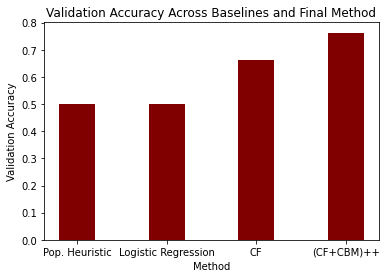

In [567]:
plt.bar(x_labels_val, y_labels_val, color ='maroon',
        width = 0.4)
 
plt.xlabel("Method")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Across Baselines and Final Method")
plt.show()

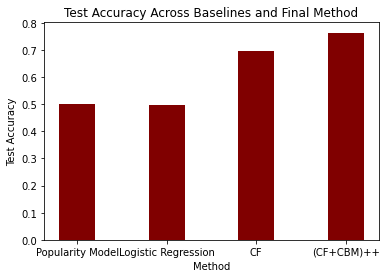

In [574]:
plt.bar(x_labels_test, y_labels_test, color ='maroon',
        width = 0.4)
 
plt.xlabel("Method")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Across Baselines and Final Method")
plt.show()